<a href="https://colab.research.google.com/github/DeepLearningSaeid/Grad/blob/main/Chapter_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This code installs the Autokeras library and imports the required libraries.
#  Autokeras is an open-source library that uses Bayesian optimization and reinforcement learning to optimize machine learning models. 
#  The timeit library is used to measure the execution time of code snippets. The numpy library is used for scientific computing with Python. 
#  The train_test_split function from sklearn.model_selection is used to split the dataset into training and test sets. 
#  The matplotlib library is used for data visualization. 
#  The Model, Sequential, Input, Embedding, Dense, concatenate, Dropout, Flatten, and Activation classes from the keras.layers module 
#  are used to define the architecture of a neural network. The backend module from keras is used to access the functions from the backend (e.g., TensorFlow). 
#  The get_custom_objects function from keras.utils.generic_utils is used to register custom objects for serialization and deserialization. 
#  The np_utils, to_categorical, and plot_model functions from keras.utils 
#  are used for data preprocessing, creating a categorical representation of data, and visualizing the model architecture. 
#  The random seed is set to 110 to ensure reproducibility of results.

# Install Autokeras library
!pip install autokeras

# Import required libraries
import autokeras as ak
import timeit
import numpy as np
import tensorflow as tf
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.models import Model, Sequential
from keras.layers import Input, Embedding, Dense, concatenate, Dropout, Flatten, Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
from keras.utils import np_utils, to_categorical, plot_model

# Set random seed
np.random.seed(110)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# This code defines a number of custom activation functions that can be used in a Keras model. 
# The get_custom_objects function is used to retrieve a dictionary mapping names to custom objects (such as functions),
# and the update function is used to add the custom activation functions to this dictionary.

# Here is a brief description of each function:

#     x_1: This function raises the input to the power of 1, which is equivalent to returning the input as is.
#     x_2: This function returns the square of the input divided by 2.
#     x_2_: This function returns the square of the input divided by 24.
#     x_2__: This function returns the square of the input divided by 720.
#     x_2___: This function returns the square of the input divided by 40320.

# After these functions are defined, they can be used as activation functions in a Keras model 
# by using the names 'X_1', 'X_2', 'X_2_', 'X_2__', and 'X_2___', respectively. 
# For example, to use the x_2 function as an activation, you would use Dense(hidden_dimention, activation='X_2').

#Define custom activation functions

def x_1(x):
# """Returns x^1"""
  return K.pow(x, 1)
  
# Register x_1 as a custom activation function
get_custom_objects().update({'X_1': Activation(x_1)})

def x_2(x):
# """Returns (x^2)/2"""
  return (K.pow(x, 2)) / 2

# Register x_2 as a custom activation function
get_custom_objects().update({'X_2': Activation(x_2)})

def x_2_(x):
# """Returns (x^2)/24"""
  return (K.pow(x, 2)) / 24

# Register x_2_ as a custom activation function
get_custom_objects().update({'X_2_': Activation(x_2_)})

def x_2__(x):
# """Returns (x^2)/720"""
  return (K.pow(x, 2)) / 720

# Register x_2__ as a custom activation function
get_custom_objects().update({'X_2__': Activation(x_2__)})

def x_2___(x):
# """Returns (x^2)/40320"""
  return (K.pow(x, 2)) / 40320

# Register x_2___ as a custom activation function
get_custom_objects().update({'X_2___': Activation(x_2___)})

In [3]:
# This code defines a number of functions that can be used for testing purposes. Here is a brief description of each function:

#     power_: This function raises the input to the power of a specified number.
#     sigmoid_array: This function applies the sigmoid function element-wise to the input array.
#     exp_: This function applies the exponential function element-wise to the input array.
#     log_: This function applies the natural logarithm element-wise to the input array.
#     generate_random: This function generates a 2D array of random numbers between 0.01 and 0.99.
#     fun_1: This function returns a combination of the square of the input and the sigmoid of the input.
#     fun_2: This function returns a combination of the fifth power of the input, the sigmoid of the input, the exponential of the input, and the natural 
#      logarithm of the input.
#     fun_3: This function returns a combination of the 20th power of the input, the sigmoid of the input, the exponential of the input, 
#      and the natural logarithm of the input.


def power_(x, n):
    return np.power(x, n)

def sigmoid_array(x):
    return 1 / (1 + np.exp(-x))

def exp_(x):
    return np.exp(x)

def log_(x):
    return np.log(x)

def generate_random(shape_1, shape_2):
    temp = np.random.random(shape_1 * shape_2)
    temp = np.random.uniform(low=0.01, high=0.99, size=(shape_1 * shape_2))
    temp1 = temp.reshape(shape_1, shape_2)
    return temp1

def fun_1(x):
    return 1 / 2 * power_(x, 2) - 5 * sigmoid_array(x)

def fun_2(x):
    return 6 * power_(x, 5) - 3 * sigmoid_array(x) + exp_(x) - 9 * log_(x)

def fun_3(x):
    return 22 * power_(x, 20) + sigmoid_array(x) + 2 * exp_(x) + 5 * log_(x)


In [4]:
# This code defines a function plot_loss that creates a single plot with six subplots.
#  Each subplot visualizes the training and test loss for a particular model architecture over the number of epochs.
#  The function takes in the following arguments:

#     size: The maximum value for the y-axis of all subplots.
#     in_1, in_2, ..., in_6: The History objects for the six model architectures.
#     title: The title for each subplot.

# The function first defines a helper function plot_subplot that takes in a subplot number, a History object, and a title,
# and creates a single subplot with the training and test loss for that model architecture. 
# The plot_loss function then calls plot_subplot for each of the six model architectures.

def plot_loss(size, in_1, in_2, in_3, in_4, in_5, in_6):
    # Set font size for all subplots
    plt.rcParams.update({'font.size': 16})
    
    def plot_subplot(subplot_num, history, title):
        # Extract training and test loss from history object
        training_loss = history.history['loss']
        test_loss = history.history['val_loss']
        
        # Create list of epochs
        epoch_count = range(1, len(training_loss) + 1)
        
        # Create subplot and plot training and test loss
        plt.subplot(subplot_num)
        plt.plot(epoch_count, training_loss, 'r--')
        plt.plot(epoch_count, test_loss, 'b-')
        
        # Add legend and labels
        plt.legend(['Training Loss', 'Test Loss'])
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        
        # Set y-axis limit
        plt.ylim(0, size)
        
        # Add title to subplot
        plt.title(title)
    
    # Create figure with 6 subplots
    plt.figure(figsize=(20, 10))
    
    # Plot training and test loss for each model architecture
    plot_subplot(231, in_1, 'Architecture 1')
    plot_subplot(232, in_2, 'Architecture 2')
    plot_subplot(233, in_3, 'Architecture 3')
    plot_subplot(234, in_4, 'Architecture 4')
    plot_subplot(235, in_5, 'Architecture 5')
    plot_subplot(236, in_6, 'Architecture 6')


In [5]:
# This function plots the shapes of the input test functions on six subplots. 
# It takes six inputs, each of which is an array containing three arrays. 
# The first array of each input contains the input values of the test function,
#  the second array contains the output values of the test function, 
#  and the third array contains the predicted output values of the test function. 
#  The subplots are arranged in a 2x3 grid and the shapes of the test functions are plotted on each subplot using the scatter function. 
#  The title function is used to label each subplot with the name of the architecture being plotted. 
#  The subplots_adjust function is used to adjust the spacing between subplots. Finally, the show function is used to display the plots.


def plot_shape(in_1,in_2,in_3,in_4,in_5,in_6):
    # Set up the plot with a figure size of (20,10)
    plt.figure(figsize=(20,10))
    # Update the font size of the plot to 16
    plt.rcParams.update({'font.size': 16})

    # Plot the first subplot with the input data
    plt.subplot(231)
    plt.scatter(in_1[0], in_1[1])
    plt.scatter(in_1[0], in_1[2])
    plt.title('Architure 1')

    # Plot the second subplot with the input data
    plt.subplot(232)
    plt.scatter(in_2[0], in_2[1])
    plt.scatter(in_2[0], in_2[2])
    plt.title('Architure 2')

    # Plot the third subplot with the input data
    plt.subplot(233)
    plt.scatter(in_3[0], in_3[1])
    plt.scatter(in_3[0], in_3[2])
    plt.title('Architure 3')

    # Plot the fourth subplot with the input data
    plt.subplot(234)
    plt.scatter(in_4[0], in_4[1])
    plt.scatter(in_4[0], in_4[2])
    plt.title('Architure 4')
    
    # Plot the fifth subplot with the input data
    plt.subplot(235)
    plt.scatter(in_5[0], in_5[1])
    plt.scatter(in_5[0], in_5[2])
    plt.title('Architure 5')    
    
    # Plot the sixth subplot with the input data
    plt.subplot(236)
    plt.scatter(in_6[0], in_6[1])
    plt.scatter(in_6[0], in_6[2])
    plt.title('Our Architure')

    # Adjust the subplot layout
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0010, right=0.95, hspace=0.3, wspace=0.18)

    # Show the plot
    plt.show()


In [6]:
# The function plot_ takes a Keras model's training history as input and plots the training loss and test loss over the number of epochs.
#  It uses matplotlib to create the plot and displays it to the user. 
#  The x-axis represents the epoch count, the y-axis represents the loss value, and the training loss is plotted in red with a dashed line and 
#  the test loss is plotted in blue with a solid line. The legend labels the two curves as "Training Loss" and "Test Loss",
#   and the x-axis and y-axis are labeled as "Epoch" and "Loss" respectively. The plot is then displayed to the user using the show function.
def plot_(history):
    # Retrieve the training and test loss values
    training_loss = history.history['loss']
    test_loss = history.history['val_loss']

    # Generate epoch count
    epoch_count = range(1, len(training_loss) + 1)

    # Plot the training and test loss
    plt.plot(epoch_count, training_loss, 'r--')
    plt.plot(epoch_count, test_loss, 'b-')
    plt.legend(['Training Loss', 'Test Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()


In [7]:
# The function visualize_result takes in a history object, X test data, Y test data, and a model. 
# It first calls the plot_ function to plot the training and test loss over the epochs. 
# It then plots the X test data against the Y test data as a scatter plot. 
# It then generates predictions for the X test data using the model, and plots those predictions against the X test data as a scatter plot.
def visualize_result(history,X_test, Y_test,model):
  # Plot the loss curve
  plot_(history)
  # Scatter plot of the true test data
  plt.scatter(X_test, Y_test)
  # Scatter plot of the model's predicted output
  predict=model.predict(X_test)
  plt.scatter(X_test, predict)
  plt.show()

In [8]:
#Creates dataset
dim_train=1000
dim_test=200

X=generate_random(dim_train,3)
Y=generate_random(dim_train,3)
    
Y[:,0]=fun_1(X[:,0])
Y[:,1]=fun_2(X[:,1])
Y[:,2]=fun_3(X[:,2])
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=1234)

def data_prep(x_train,x_test,y_train,y_test,column):
  X_train=x_train[:,column]
  Y_train=y_train[:,column]
  X_test=x_test[:,column]
  Y_test=y_test[:,column]
  return X_train,Y_train,X_test,Y_test

In [9]:
def model_training_visualization(model_input,X_train_1,Y_train_1,X_test_1,Y_test_1,number_epo_1,batch_size_):
  # Train model
  start = timeit.default_timer()
  history = model_input.fit(X_train_1, Y_train_1, epochs=number_epo, verbose=0, batch_size=batch_size_,
                          validation_data=(X_test_1, Y_test_1))
  end = timeit.default_timer()
  print("Run Time : %f" % (end - start))

  # Make predictions and visualize results
  predict = model_input.predict(X_test_1)
  visualize_result(history, X_test_1, Y_test_1, model_input)
  return [X_test_1, Y_test_1, predict, history]

In [10]:
# Hyper perameters
number_epo=50
input_dim=1
output_dim=1

In [11]:
hidden_dimention = 50

# Model definition
model = Sequential()
in_ = Input(shape=(input_dim,))

# First set of layers
layer_1_x_1 = Dense(hidden_dimention, activation='X_1')(in_)
layer_1_x_2 = Dense(hidden_dimention, activation='X_2')(in_)
concatenate_first_layer = concatenate([layer_1_x_1, layer_1_x_2])

# Second set of layers
layer_x_3_x_4 = Dense(hidden_dimention, activation='X_2_')(concatenate_first_layer)
layer_x_5_x_6 = Dense(hidden_dimention, activation='X_2__')(layer_x_3_x_4)
layer_x_7_x_8 = Dense(hidden_dimention, activation='X_2___')(layer_x_5_x_6)

# Concatenate the two sets of layers
concatenate_second_layer = concatenate([layer_1_x_1, layer_1_x_2, concatenate_first_layer,
                                        layer_x_3_x_4, layer_x_5_x_6, layer_x_7_x_8])

# Output layer
out_put_first_layer = Dense(hidden_dimention, activation='linear')(concatenate_second_layer)
out_put = Dense(output_dim, activation='linear')(out_put_first_layer)

# Create model
Our_model = Model(in_ , out_put)
Our_model.compile(loss='mean_squared_error', optimizer='adam')


Run Time : 14.574625
7/7 [==============================] - 0s 3ms/step


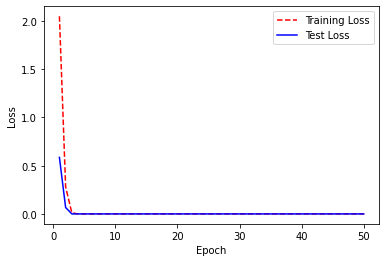

7/7 [==============================] - 0s 4ms/step


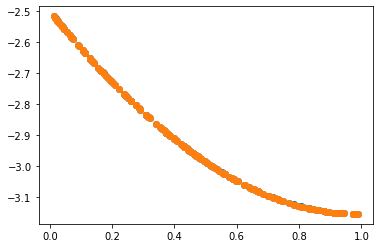

Run Time : 11.985370
7/7 [==============================] - 0s 2ms/step


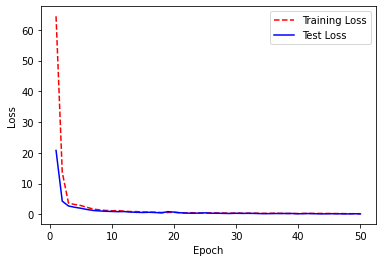

7/7 [==============================] - 0s 2ms/step


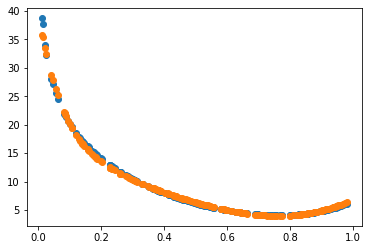

Run Time : 7.624101
7/7 [==============================] - 0s 2ms/step


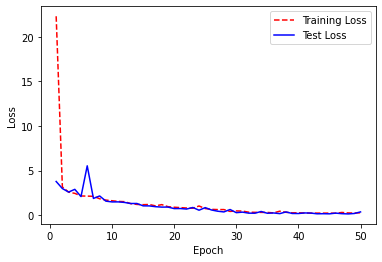

7/7 [==============================] - 0s 2ms/step


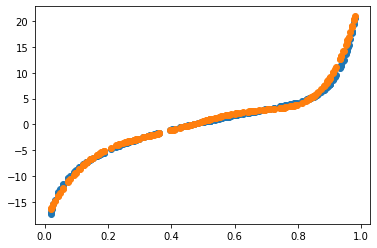

In [12]:
# this code is preparing data, training a model, and then visualizing the results of the model's performance. 
# The data preparation includes reshaping the data into the correct shape for the model and selecting a particular column of the data to use. 
# The model is then trained on this data for a specified number of epochs, and the time it takes to train the model is recorded.
# Finally, the model is used to make predictions on the test set, and the results are visualized.
#   The results of the model's performance, including the test data and predictions, are stored in the F_1_our_model variable.

# Preprocess data
column = 0
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

# # Train model
F_1_our_model = model_training_visualization(Our_model,X_train,Y_train,X_test,Y_test,number_epo,10)


# Preprocess data
column = 1
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

# Train model

F_2_our_model = model_training_visualization(Our_model,X_train,Y_train,X_test,Y_test,number_epo,10)


# Preprocess data
column = 2
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

# Train model

F_3_our_model = model_training_visualization(Our_model,X_train,Y_train,X_test,Y_test,number_epo,10)

In [13]:
#Second Traditional model for Function 3
archicture_1 = Sequential()
archicture_1.add(Dense(5, input_dim=input_dim, activation='relu'))
archicture_1.add(Dense(10, activation='relu'))
archicture_1.add(Dense(50, activation='tanh'))
archicture_1.add(Dense(18, activation='relu'))
archicture_1.add(Dense(15, activation='tanh'))
archicture_1.add(Dense(18, activation='sigmoid'))
archicture_1.add(Dropout(0.2))
archicture_1.add(Dense(8, activation='relu'))
archicture_1.add(Dropout(0.2))
archicture_1.add(Dense(output_dim, activation='relu'))
#model.summary()
archicture_1.compile(loss='mean_squared_error', optimizer='adam')

Run Time : 13.616644
7/7 [==============================] - 0s 2ms/step


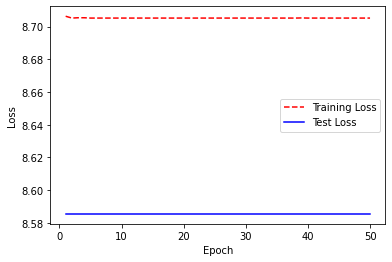

7/7 [==============================] - 0s 3ms/step


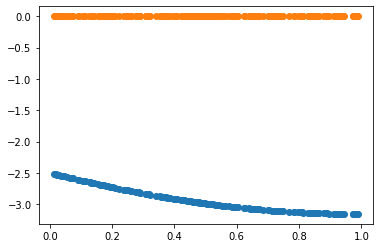

Run Time : 13.031290
7/7 [==============================] - 0s 2ms/step


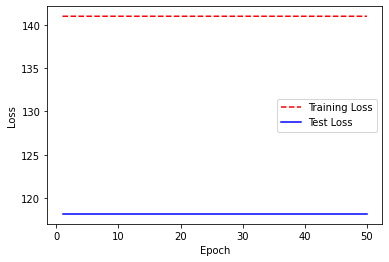

7/7 [==============================] - 0s 2ms/step


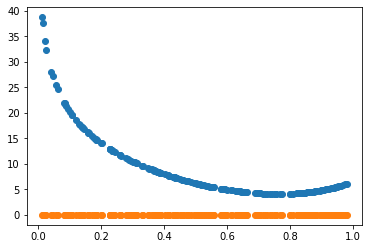

Run Time : 7.320396
7/7 [==============================] - 0s 2ms/step


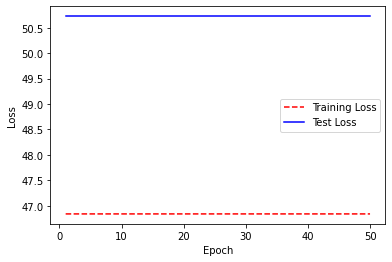

7/7 [==============================] - 0s 2ms/step


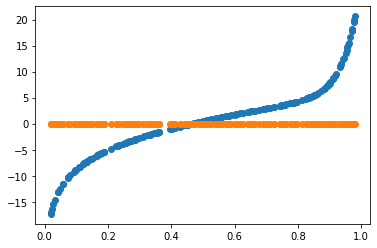

In [14]:
column = 0
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

# # Train model
F_1_archicture_1 = model_training_visualization(archicture_1,X_train,Y_train,X_test,Y_test,number_epo,10)

column = 1
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

# # Train model
F_2_archicture_1 = model_training_visualization(archicture_1,X_train,Y_train,X_test,Y_test,number_epo,10)

column = 2
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

# # Train model
F_3_archicture_1 = model_training_visualization(archicture_1,X_train,Y_train,X_test,Y_test,number_epo,10)

In [15]:
#Fifth Traditional Model
archicture_2 = Sequential()
archicture_2.add(Dense(5, input_dim=input_dim, activation='softplus'))
archicture_2.add(Dense(10, activation='softplus'))
archicture_2.add(Dense(20, activation='tanh'))
archicture_2.add(Dense(15, activation='relu'))
archicture_2.add(Dense(25, activation='tanh'))
archicture_2.add(Dense(20, activation='sigmoid'))
archicture_2.add(Dense(25, activation='relu'))
archicture_2.add(Dense(output_dim, activation='softplus'))
archicture_2.add(Dropout(0.2))
archicture_2.compile(loss='mean_squared_error', optimizer='adam')

Run Time : 10.898237
7/7 [==============================] - 0s 2ms/step


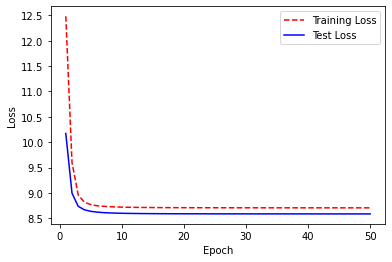

7/7 [==============================] - 0s 2ms/step


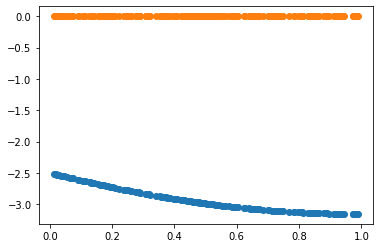

Run Time : 10.263689
7/7 [==============================] - 0s 2ms/step


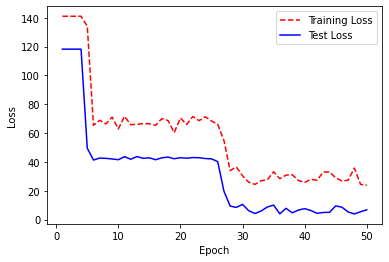

7/7 [==============================] - 0s 2ms/step


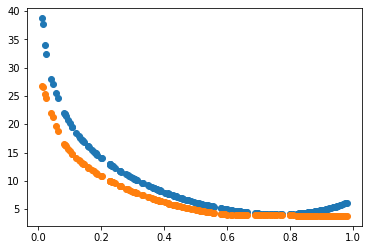

Run Time : 7.018265
7/7 [==============================] - 0s 2ms/step


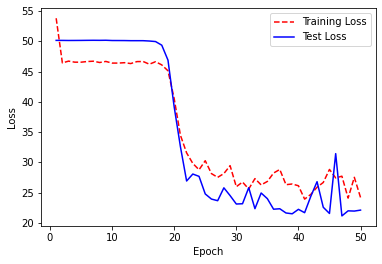

7/7 [==============================] - 0s 2ms/step


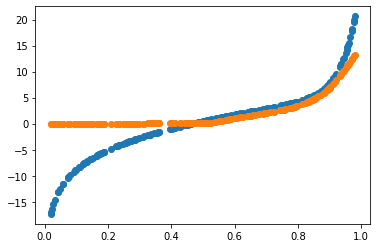

In [16]:
column = 0
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

# # Train model
F_1_archicture_2 = model_training_visualization(archicture_2,X_train,Y_train,X_test,Y_test,number_epo,10)

column = 1
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

# # Train model
F_2_archicture_2 = model_training_visualization(archicture_2,X_train,Y_train,X_test,Y_test,number_epo,10)

column = 2
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

# # Train model
F_3_archicture_2 = model_training_visualization(archicture_2,X_train,Y_train,X_test,Y_test,number_epo,10)

Epoch 1/5
25/25 [==============================] - 1s 4ms/step - loss: 122.6387 - mean_squared_error: 122.6387
Epoch 2/5
25/25 [==============================] - 0s 4ms/step - loss: 51.7476 - mean_squared_error: 51.7476
Epoch 3/5
25/25 [==============================] - 0s 5ms/step - loss: 7.3572 - mean_squared_error: 7.3572
Epoch 4/5
25/25 [==============================] - 0s 4ms/step - loss: 6.2972 - mean_squared_error: 6.2972
Epoch 5/5
25/25 [==============================] - 0s 4ms/step - loss: 5.8213 - mean_squared_error: 5.8213
Run Time : 10.607307
7/7 [==============================] - 0s 2ms/step


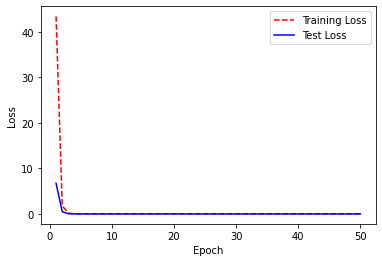

7/7 [==============================] - 0s 2ms/step


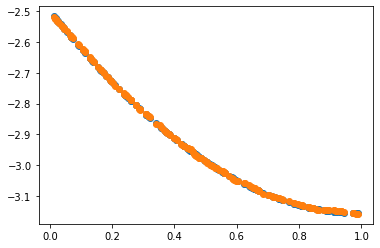

Run Time : 20.539256
7/7 [==============================] - 0s 3ms/step


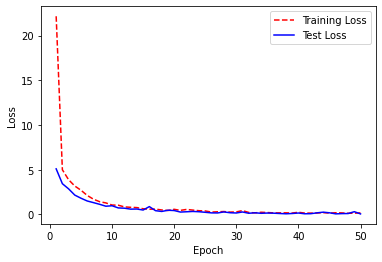

7/7 [==============================] - 0s 2ms/step


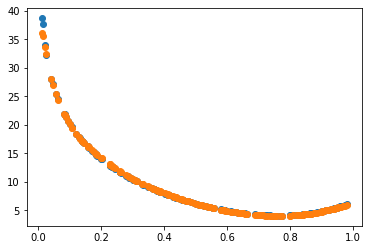

Run Time : 8.377419
7/7 [==============================] - 0s 2ms/step


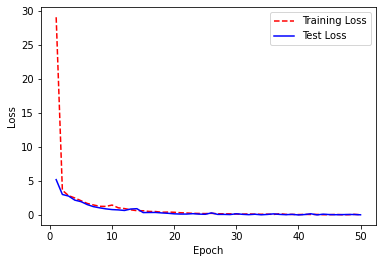

7/7 [==============================] - 0s 2ms/step


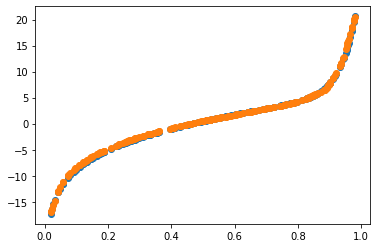

In [50]:
column = 1
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

train_set = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
test_set = tf.data.Dataset.from_tensor_slices(
    (X_test, Y_test)
)

clf = ak.StructuredDataRegressor(
    overwrite=True, max_trials=10
) 
# Feed the tensorflow Dataset to the classifier.
clf.fit(train_set, epochs=5,verbose=0)
autokeras_model=clf.export_model()


column = 0
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

# # Train model
F_1_autokeras = model_training_visualization(autokeras_model,X_train,Y_train,X_test,Y_test,number_epo,10)

column = 1
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

# # Train model
F_2_autokeras = model_training_visualization(autokeras_model,X_train,Y_train,X_test,Y_test,number_epo,10)

column = 2
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

# # Train model
F_3_autokeras = model_training_visualization(autokeras_model,X_train,Y_train,X_test,Y_test,number_epo,10)

In [18]:
# This code performs hyperparameter tuning using grid search cross-validation on a Keras neural network model for regression.
#  The model has three dense layers, with dropout and kernel initializers applied between each layer. 
#  The hyperparameters that are being tuned are the batch size, number of epochs, learning rate, dropout rate, activation functions, kernel initializers,
#   and number of neurons in each layer. The model is trained on the input data X_train and
#   the output data Y_train. The best hyperparameter combination is determined based on mean squared error,
#   which is used as the evaluation metric. The results of the grid search, including the best combination 
#   and the performance of all combinations, are printed to the console. The total runtime of the code is also printed.


def create_best_model(best_param):
    model = Sequential()
    model.add(
        Dense(
            best_param['neuron1'],
            input_dim=1,
            kernel_initializer=best_param['init'],
            activation=best_param['activation_function'],
        )
    )
    model.add(Dropout(best_param['dropout_rate']))
    model.add(
        Dense(
            best_param['neuron2'],
            input_dim=best_param['neuron1'],
            kernel_initializer=best_param['init'],
            activation=best_param['activation_function_1'],
        )
    )
    model.add(Dropout(best_param['dropout_rate']))
    model.add(Dense(1, activation=best_param['activation_function_2']))

    optimizer = tf.keras.optimizers.Adam(learning_rate=best_param['learning_rate'])
    model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=['mse'])
    return model

def create_model(
    learning_rate,
    dropout_rate,
    activation_function,
    activation_function_1,
    activation_function_2,
    init,
    neuron1,
    neuron2,
):
    model = Sequential()
    model.add(
        Dense(
            neuron1,
            input_dim=1,
            kernel_initializer=init,
            activation=activation_function,
        )
    )
    model.add(Dropout(dropout_rate))
    model.add(
        Dense(
            neuron2,
            input_dim=neuron1,
            kernel_initializer=init,
            activation=activation_function_1,
        )
    )
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation=activation_function_2))

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=['mse'])
    return model


# Create the model
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the grid search parameters
param_grids = {
    'batch_size': [10],
    'epochs': [10],
    'learning_rate': [0.01],
    'dropout_rate': [0.1],
    'activation_function': ['softmax', 'relu', 'tanh', 'linear'],
    'activation_function_1': ['softmax', 'relu', 'tanh', 'linear'],
    'activation_function_2': ['softmax', 'relu', 'tanh', 'linear'],
    'init': ['uniform'],
    'neuron1': [50, 100, 150],
    'neuron2': [20, 40, 80],
}

# Build and fit the GridSearchCV
kfold = KFold(n_splits=2)
grid = GridSearchCV(estimator=model, param_grid=param_grids, cv=kfold, verbose=0)
grid_result = grid.fit(X_train, Y_train)

# Summarize the results
print(f"Best score: {grid_result.best_score_}, using {grid_result.best_params_}")
means = grid_result.cv_results_["mean_test_score"]
stds = grid_result.cv_results_["std_test_score"]
params = grid_result.cv_results_["params"]
for mean, stdev, param in zip(means, stds, params):
    print(f"{mean}, {stdev} with: {param}")

# Print runtime
end = timeit.default_timer()
print("Run Time : %f" % (end-start))


<ipython-input-18-06737556c577>:42: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best : -1.7612167596817017, using {'activation_function': 'linear', 'activation_function_1': 'relu', 'activation_function_2': 'linear', 'batch_size': 10, 'dropout_rate': 0.1, 'epochs': 10, 'init': 'uniform', 'learning_rate': 0.01, 'neuron1': 100, 'neuron2': 80}
-46.72833251953125,4.958072662353516 with: {'activation_function': 'softmax', 'activation_function_1': 'softmax', 'activation_function_2': 'softmax', 'batch_size': 10, 'dropout_rate': 0.1, 'epochs': 10, 'init': 'uniform', 'learning_rate': 0.01, 'neuron1': 50, 'neuron2': 20}
-46.72833251953125,4.958072662353516 with: {'activation_function': 'softmax', 'activation_function_1': 'softmax', 'activation_function_2': 'softmax', 'batch_size': 10, 'dropout_rate': 0.1, 'epochs': 10, 'init': 'uniform', 'learning_rate': 0.01, 'neuron1': 50, 'neuron2': 40}
-46.72833251953125,4.958072662353516 with: {'activation_function': 'softmax', 'activation_function_1': 'softmax', 'activation_function_2': 'softmax', 'batch_size': 10, 'dropout_rate': 0.1,

In [47]:
search_model=create_best_model(grid_result.best_params_)

Run Time : 7.096389
7/7 [==============================] - 0s 2ms/step


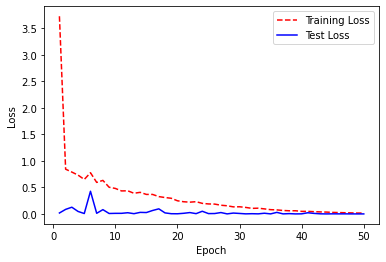

7/7 [==============================] - 0s 1ms/step


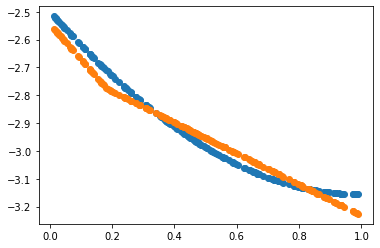

Run Time : 6.807455
7/7 [==============================] - 0s 2ms/step


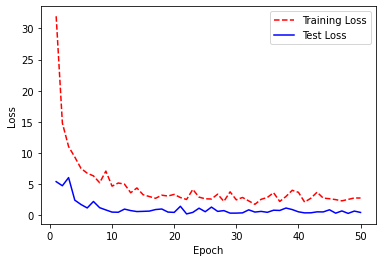

7/7 [==============================] - 0s 2ms/step


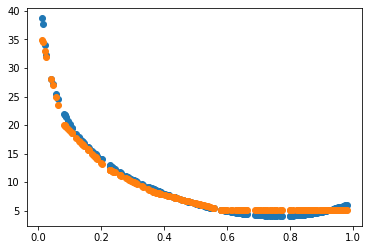

Run Time : 10.269217
7/7 [==============================] - 0s 2ms/step


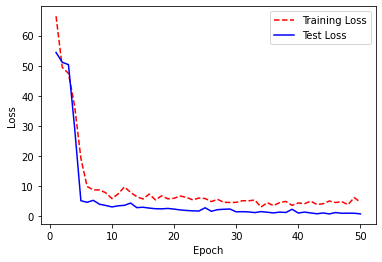

7/7 [==============================] - 0s 2ms/step


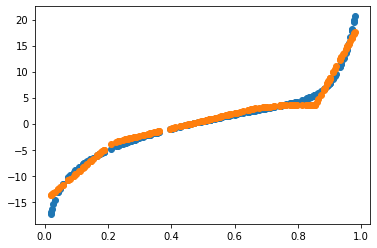

In [49]:



column = 0
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

# # Train model
F_1_Search = model_training_visualization(search_model,X_train,Y_train,X_test,Y_test,number_epo,10)

column = 1
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

# # Train model
F_2_Search = model_training_visualization(search_model,X_train,Y_train,X_test,Y_test,number_epo,10)

column = 2
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

# # Train model
F_3_Search = model_training_visualization(search_model,X_train,Y_train,X_test,Y_test,number_epo,10)

In [20]:
#Plots Losses
plot_loss(30,F_1_archicture_1[3],F_1_archicture_2[3],F_1_archicture_3[3],F_1_archicture_4[3],F_1_archicture_5[3],F_1_our_model[3],)

NameError: ignored

In [ ]:
#Plot Losses
plot_loss(150,F_2_archicture_1[3],F_2_archicture_2[3],F_2_archicture_3[3],F_2_archicture_4[3],F_2_archicture_5[3],F_2_our_model[3],)

In [ ]:
#Plot Losses
plot_loss(70,F_3_archicture_1[3],F_3_archicture_2[3],F_3_archicture_3[3],F_3_archicture_4[3],F_3_archicture_5[3],F_3_our_model[3],)

In [ ]:
#Plots Shapes
plot_shape(F_1_archicture_1,F_1_archicture_2,F_1_archicture_3,F_1_archicture_4,F_1_archicture_5,F_1_our_model,)


In [ ]:
#Plots Shapes 
plot_shape(F_2_archicture_1,F_2_archicture_2,F_2_archicture_3,F_2_archicture_4,F_2_archicture_5,F_2_our_model,)

In [ ]:
#Plots Shapes
plot_shape(F_3_archicture_1,F_3_archicture_2,F_3_archicture_3,F_3_archicture_4,F_3_archicture_5,F_3_our_model)

In [ ]:
###############################################################################
def fun_3(co,x):
    return co[0]*power_(x, co[1])+co[2]*sigmoid_array(co[3]*x)+co[4]*exp_(co[5]*x*0.1)+co[6]*log_(co[7]*x)
###############################################################################

In [21]:
import random
def rand_list():
  coefficient= [None for _ in range(8)]
  coefficient[0]= random.randint(-10, 10)
  coefficient[2]= random.randint(-10, 10)
  coefficient[4]= random.randint(-10, 10)
  coefficient[6]= random.randint(-10, 10)
  coefficient[1]= random.randint(1,50)
  coefficient[3]= random.randint(1,50)
  coefficient[5]= random.randint(1,50)
  coefficient[7]= random.randint(1,50)
  return coefficient


In [ ]:



Y_test_temp[:,2]=fun_2(X_test_temp[:,2])
Y_train_temp[:,2]=fun_2(X_train_temp[:,2])


In [ ]:
Y_train_temp[:,0]=fun_1(X_train_temp[:,0])
Y_train_temp[:,1]=fun_2(X_train_temp[:,1])
    

Y_test_temp[:,0]=fun_1(X_test_temp[:,0])
Y_test_temp[:,1]=fun_2(X_test_temp[:,1])


In [ ]:
column=1
coefficient=rand_list()
Y_test_temp[:,1]=fun_3(coefficient,X_test_temp[:,1])
Y_train_temp[:,1]=fun_3(coefficient,X_train_temp[:,1])

X_train=X_train_temp[:,column]
Y_train=Y_train_temp[:,column]
X_test=X_test_temp[:,column]
Y_test=Y_test_temp[:,column]


#F_3_archicture_our

start = timeit.default_timer()
history = model.fit(X_train,Y_train,epochs=20,verbose=1,batch_size=10,validation_data=(X_test, Y_test)) 
end = timeit.default_timer()
print("Run Time : %f" % (end-start))
plot_(history)
plt.scatter(X_test, Y_test)
predict=model.predict(X_test)
plt.scatter(X_test, predict)

# F_3_our_model=[X_test,Y_test,predict,history]

In [ ]:
print(history.history['val_loss'])


In [ ]:
print(coefficient)

In [ ]:
for i in range(5):  
  column=1
  coefficient=rand_list()
  Y_test_temp[:,1]=fun_3(coefficient,X_test_temp[:,1])
  Y_train_temp[:,1]=fun_3(coefficient,X_train_temp[:,1])

  X_train=X_train_temp[:,column]
  Y_train=Y_train_temp[:,column]
  X_test=X_test_temp[:,column]
  Y_test=Y_test_temp[:,column]


  #F_3_archicture_our

  start = timeit.default_timer()
  history = model.fit(X_train,Y_train,epochs=20,verbose=1,batch_size=10,validation_data=(X_test, Y_test)) 
  end = timeit.default_timer()
  print("Run Time : %f" % (end-start))
  # plot_(history)
  plt.scatter(X_test, Y_test)
  predict=model.predict(X_test)
  plt.scatter(X_test, predict)

  # F_3_our_model=[X_test,Y_test,predict,history]